## Imports

In [1]:
from JSU_lib import *

## Functions

In [150]:
# Function to apply the transformation
def apply_rotation(row):
    # Extract the rotation matrix using rep_chain
    matrix = rot_matrices[row['rep_chain']]
    # Extract the centre tuple and convert to numpy array
    centre_vector = np.array(row['centre'])
    translated_centre = centre_vector - orig_centroids[row['rep_chain']]
    # Perform matrix multiplication
    transformed_centre = np.dot(matrix, translated_centre)
    round_centre = tuple([round(el, 3) for el in transformed_centre])
    return round_centre

def calculate_distance(row):
    # Convert tuples to numpy arrays for vector operations
    centre_mat_vector = np.array(row['centre_mat'])
    centre_trans_vector = np.array(row['centre_trans'])
    # Calculate Euclidean distance using numpy.linalg.norm
    distance = np.linalg.norm(centre_mat_vector - centre_trans_vector)
    return distance

## Input data

In [33]:
clean_rep_chains_dir = "/Users/2394007/Documents/PHD/LOCAL/JSU_site_predictors/DATA/clean_rep_chains"
vnegnn_preds_dir = "/Users/2394007/Documents/PHD/LOCAL/JSU_site_predictors/DATA/VNEGNN_PDB_preds/predictions"
trans_rep_chains_dir = "/Users/2394007/Documents/PHD/LOCAL/JSU_site_predictors/DATA/trans_rep_chains"

In [3]:
vnegnn_preds_files = sorted([el for el in os.listdir(vnegnn_preds_dir) if el.endswith(".csv")])

In [4]:
len(vnegnn_preds_files)

4430

In [5]:
vnegnn_preds_files[:5]

['1a52_A_prediction.csv',
 '1a5h_B_prediction.csv',
 '1a9w_E_prediction.csv',
 '1ags_B_prediction.csv',
 '1aii_A_prediction.csv']

In [6]:
LIGYSIS_reps = read_from_pickle("./results/ligysis_3448_chains.pkl")
len(set(LIGYSIS_reps).intersection(set(["_".join(el.split("_")[:2]) for el in vnegnn_preds_files])))

3445

## Concatenating VN-EGNN pocket dataframes

In [7]:
errors = []
success = []
no_pockets = []
vnegnn_dfs = []

In [8]:
for i, vnegnn_preds_file in enumerate(vnegnn_preds_files):
    
    if i % 100 == 0:
       print(i) 
    
    if vnegnn_preds_file in success:
        continue

    input_name = "_".join(vnegnn_preds_file.split("_")[:2])
    file_path = os.path.join(vnegnn_preds_dir, vnegnn_preds_file) 
    try:
        pocket_df = process_vnegnn_df(pd.read_csv(file_path))
        pocket_df["rep_chain"] = input_name.split(".")[0]
        if pocket_df.empty:
            print(f'No pockets in {input_name}')
            if vnegnn_preds_file not in no_pockets:
                no_pockets.append(vnegnn_preds_file)
            continue
        
        success.append(vnegnn_preds_file)
        vnegnn_dfs.append(pocket_df)
    except:
        print(f'ERROR with {input_name}')
        #raise
        if vnegnn_preds_file not in errors:
            errors.append(vnegnn_preds_file)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400


In [9]:
len([el for el in vnegnn_dfs if not el.empty]) #4430

4430

In [10]:
cc = ["rep_chain", "ID", "RANK", "score", "centre"]
all_vnegnn_pockets = pd.concat(vnegnn_dfs).reset_index(drop = True)[cc]

In [14]:
print(len(errors))

0


In [11]:
print(len(no_pockets)) #0

0


In [12]:
all_vnegnn_pockets.shape[0] #22411

22411

In [28]:
#all_vnegnn_pockets.to_pickle("./results/vnegnn_pockets.pkl")

In [13]:
len(set(LIGYSIS_reps).intersection(set(all_vnegnn_pockets.rep_chain.tolist()))) #3445

3445

## Get pocket residues (VN-EGNN ran on .clean.pdb, therefore we must use those PDBs to get pocket residues)

In [17]:
errors = []
success = []
vnegnn_ress_dict = {}

In [18]:
all_vnegnn_pockets_reps = all_vnegnn_pockets.rep_chain.unique().tolist()

In [19]:
for i, rep_chain in enumerate(all_vnegnn_pockets_reps):
    
    if i % 100 == 0:
       print(i) 
    
    if rep_chain in success:
        continue

    rep_chain_sites = all_vnegnn_pockets.query('rep_chain == @rep_chain')
    rep_chain_pdb = os.path.join(clean_rep_chains_dir, f'{rep_chain}.clean.pdb')
    rep_chain_df = PDBXreader(inputfile = rep_chain_pdb).atoms(format_type="pdb", excluded=())
    rep_chain_df['XYZ'] = list(zip(rep_chain_df['Cartn_x'].round(3), rep_chain_df['Cartn_y'].round(3), rep_chain_df['Cartn_z'].round(3)))
    try:
        for _, row in rep_chain_sites.iterrows():
            site_centroid = row.centre
            rep_chain_df['dist2centroid'] = rep_chain_df['XYZ'].apply(calculate_distance, centroid=site_centroid)
            pocket_ress = sorted(rep_chain_df.query('dist2centroid < 6').label_seq_id_full.unique().tolist(), key=custom_sort)
            vnegnn_ress_dict[(rep_chain, row.ID)] = pocket_ress                                
        success.append(rep_chain)
    except:
        print(f'ERROR with {rep_chain}')
        if rep_chain not in errors:
            errors.append(rep_chain)
        raise
    #break

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400


In [20]:
print(len(success)) #4430
print(len(vnegnn_ress_dict)) #22411
print(len(errors)) #0

4430
22411
0


In [21]:
save_to_pickle(vnegnn_ress_dict, "./results/VNEGNN_pocket_ress_6A.pkl")

In [22]:
all_vnegnn_pockets["aas"] = all_vnegnn_pockets.set_index(["rep_chain", "ID"]).index.map(vnegnn_ress_dict)

In [23]:
all_vnegnn_pockets["n_aas"] = all_vnegnn_pockets['aas'].apply(lambda x: len(x)) 

In [24]:
all_vnegnn_pockets.query('rep_chain == "1a52_A"')

,rep_chain,ID,RANK,score,centre,aas,n_aas
0,1a52_A,1,3,0.914543,"(107.237, 13.743, 95.017)","[50, 88, 92, 108, 125, 128, 225, 228, 229]",9
1,1a52_A,2,1,0.921467,"(107.113, 14.138, 95.474)","[50, 88, 92, 108, 125, 128, 132, 229]",8
2,1a52_A,3,5,0.903405,"(106.92, 14.314, 96.059)","[50, 88, 92, 108, 125, 229]",6
3,1a52_A,4,2,0.916810,"(106.841, 14.052, 96.027)","[50, 88, 92, 108, 125, 229]",6
4,1a52_A,5,4,0.908655,"(106.691, 14.264, 96.407)","[50, 54, 88, 91, 92, 108, 229]",7


In [25]:
all_vnegnn_pockets.query('n_aas == 0') # in deep, wide, big pockets, you might not have any residues within 5A (N=818)

,rep_chain,ID,RANK,score,centre,aas,n_aas
560,1gh7_A,2,5,-0.023721,"(28.826, -19.071, -27.833)",[],0
562,1gh7_A,4,7,-0.036910,"(8.116, 19.476, 3.003)",[],0
563,1gh7_A,5,1,0.018787,"(3.516, -13.024, -2.326)",[],0
564,1gh7_A,6,2,0.003744,"(-0.618, -13.344, -40.846)",[],0
565,1gh7_A,7,4,-0.006690,"(-16.888, 11.611, -26.266)",[],0
...,...,...,...,...,...,...,...
22280,8tar_N,1,3,-0.029535,"(231.273, 180.711, 275.77)",[],0
22281,8tar_N,2,4,-0.033827,"(273.535, 186.735, 272.612)",[],0
22282,8tar_N,3,1,-0.013700,"(264.655, 145.757, 275.284)",[],0
22283,8tar_N,4,2,-0.021023,"(252.517, 158.217, 242.451)",[],0


## Calculate RoG of VN-EGNN pockets

In [26]:
site_targets = all_vnegnn_pockets.rep_chain.unique().tolist()
len(site_targets)

4430

In [27]:
all_vnegnn_pockets.shape[0]

22411

In [28]:
cc = [
    'label_seq_id_full', 'label_comp_id', 'type_symbol',
    'label_atom_id', 'Cartn_x', 'Cartn_y', 'Cartn_z'
]

In [30]:
all_vnegnn_pockets #these centres are from VN-EGNN (clean.pdb)
                   #to compare them with the others, we should apply the
                   #transformation matrices used to transform from clean to trans

,rep_chain,ID,RANK,score,centre,aas,n_aas
0,1a52_A,1,3,0.914543,"(107.237, 13.743, 95.017)","[50, 88, 92, 108, 125, 128, 225, 228, 229]",9
1,1a52_A,2,1,0.921467,"(107.113, 14.138, 95.474)","[50, 88, 92, 108, 125, 128, 132, 229]",8
2,1a52_A,3,5,0.903405,"(106.92, 14.314, 96.059)","[50, 88, 92, 108, 125, 229]",6
3,1a52_A,4,2,0.916810,"(106.841, 14.052, 96.027)","[50, 88, 92, 108, 125, 229]",6
4,1a52_A,5,4,0.908655,"(106.691, 14.264, 96.407)","[50, 54, 88, 91, 92, 108, 229]",7
...,...,...,...,...,...,...,...
22406,8y6o_H,6,4,0.783603,"(276.259, 310.187, 255.33)","[28, 30, 73, 81, 82, 83, 84, 89, 100]",9
22407,8yhh_B,1,3,0.845100,"(18.697, 36.156, 36.722)","[80, 112, 113, 114, 115, 116, 117, 118, 119, 120]",10
22408,8yhh_B,2,1,0.891808,"(17.166, 37.219, 33.178)","[26, 110, 111, 112, 113, 114, 115, 116, 117, 337]",10
22409,8yhh_B,3,4,0.762785,"(19.866, 35.354, 39.926)","[114, 115, 116, 117, 118, 119, 120, 136, 139]",9


In [34]:
# HERE WE WILL USE TRANS FILES FOR THE CALCULATION OF THE NEW CENTRE AND ROG

T0 = time.time()
RoG_dict = {}
centres_dict_ress = {}
for i, target in enumerate(site_targets):
    if i % 500 == 0:
        print(i)
    pdb_path = os.path.join(trans_rep_chains_dir, f'{target}.trans.pdb')
    df = PDBXreader(inputfile=pdb_path).atoms(format_type="pdb", excluded=())[cc].query('label_atom_id == "CA"').reset_index(drop = True)
    target_sites_df = all_vnegnn_pockets.query('rep_chain == @target')
    for _, row in target_sites_df.iterrows():
        site_ress = row.aas
        if site_ress == []:
            RoG_dict[(target, row.ID)] = np.nan
            continue
        else:
            ress_CAs = df.query('label_seq_id_full in @site_ress')
            CAs_coords = np.array(list((zip(ress_CAs.Cartn_x, ress_CAs.Cartn_y, ress_CAs.Cartn_z))))
            center_of_mass = np.mean(CAs_coords, axis=0)
            distances_squared = np.sum((CAs_coords - center_of_mass)**2, axis=1)
            radius_of_gyration = round(np.sqrt(np.mean(distances_squared)), 2)
            RoG_dict[(target, row.ID)] = radius_of_gyration
            centres_dict_ress[(target, row.ID)] = tuple([round(v, 3) for v in center_of_mass])

    #break
TF = time.time()

0
500
1000
1500
2000
2500
3000
3500
4000


In [40]:
dTs = TF-T0

dTm = dTs/60

N_RoG = len(RoG_dict)

print(len(centres_dict_ress))

print(N_RoG)

print(round(dTm,2))

print(round(dTs/N_RoG, 5))

21812
22411
6.07
0.01625


In [36]:
save_to_pickle(RoG_dict, "./results/VNEGNN_RoG_6A_TRANS.pkl")

In [42]:
all_vnegnn_pockets["centre_trans"] = np.nan
centres = []
errs = 0
err_chains = []
for i, row in all_vnegnn_pockets.iterrows():
    try:
        centre = centres_dict_ress[(row.rep_chain, row.ID)]
        centres.append(centre)
    except:
        errs += 1
        centres.append(np.nan)
        err_chains.append(row.rep_chain)
print(errs) # 599

599


In [37]:
all_vnegnn_pockets["RoG"] = all_vnegnn_pockets.set_index(['rep_chain', 'ID']).index.map(RoG_dict)

In [43]:
all_vnegnn_pockets["centre_trans"] = centres

In [45]:
all_vnegnn_pockets.head(10)

,rep_chain,ID,RANK,score,centre,aas,n_aas,RoG,centre_trans
0,1a52_A,1,3,0.914543,"(107.237, 13.743, 95.017)","[50, 88, 92, 108, 125, 128, 225, 228, 229]",9,7.55,"(1.394, -9.77, -4.104)"
1,1a52_A,2,1,0.921467,"(107.113, 14.138, 95.474)","[50, 88, 92, 108, 125, 128, 132, 229]",8,7.79,"(3.028, -8.849, -3.212)"
2,1a52_A,3,5,0.903405,"(106.92, 14.314, 96.059)","[50, 88, 92, 108, 125, 229]",6,7.79,"(1.669, -9.473, -1.796)"
3,1a52_A,4,2,0.916810,"(106.841, 14.052, 96.027)","[50, 88, 92, 108, 125, 229]",6,7.79,"(1.669, -9.473, -1.796)"
4,1a52_A,5,4,0.908655,"(106.691, 14.264, 96.407)","[50, 54, 88, 91, 92, 108, 229]",7,6.80,"(0.465, -7.793, 0.546)"
5,1a5h_B,1,3,0.890733,"(16.48, 55.728, 29.65)","[47, 198, 199, 200, 201, 203, 221, 222, 223, 224]",10,5.86,"(2.031, 4.199, -6.004)"
6,1a5h_B,2,2,0.892031,"(17.962, 55.161, 29.479)","[198, 199, 200, 203, 221, 222, 223, 224, 225, ...",11,5.78,"(3.225, 7.13, -6.413)"
7,1a5h_B,3,5,0.876678,"(17.847, 54.55, 29.709)","[199, 200, 203, 221, 222, 223, 224, 225, 226]",9,5.70,"(2.404, 6.683, -6.89)"
8,1a5h_B,4,4,0.887769,"(17.42, 54.747, 29.687)","[47, 199, 200, 203, 221, 222, 223, 224, 225, 226]",10,6.33,"(1.751, 5.866, -7.24)"
9,1a5h_B,5,1,0.906284,"(17.295, 55.66, 29.446)","[198, 199, 200, 203, 221, 222, 223, 224, 226]",9,5.47,"(2.712, 6.103, -5.938)"


## Translating and rotating VN-EGNN predicted centroid

In [115]:
rot_matrices = read_from_pickle("./results/PDB_rot_matrices.pkl")
orig_centroids = read_from_pickle("./results/PDB_orig_centroids.pkl")

In [116]:
all_vnegnn_pockets_w_sifts['centre_mat'] = all_vnegnn_pockets_w_sifts.apply(apply_rotation, axis=1)

In [117]:
all_vnegnn_pockets_w_sifts['distance'] = all_vnegnn_pockets_w_sifts.apply(calculate_distance, axis=1)

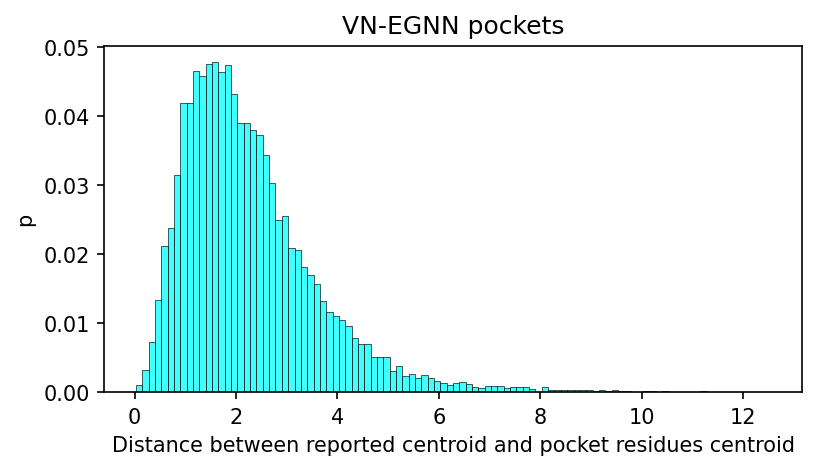

In [153]:
plt.figure(figsize = (6,3), dpi = 150)

sns.histplot(all_vnegnn_pockets_w_sifts.distance, bins = 100, stat = "proportion", color = "cyan")
plt.title("VN-EGNN pockets")
plt.xlabel("Distance between reported centroid and pocket residues centroid")
plt.ylabel("p")
plt.show()

In [142]:
all_vnegnn_pockets_w_sifts #centre_mat is the translated and rotated centre as reported by VN-EGNN

,rep_chain,ID,RANK,score,centre,aas,n_aas,RoG,centre_trans,up_aas,centre_mat,distance
0,1a52_A,1,3,0.914543,"(107.237, 13.743, 95.017)","[50, 88, 92, 108, 125, 128, 225, 228, 229]",9,7.55,"(1.394, -9.77, -4.104)","[346, 384, 388, 404, 421, 424, 521, 524, 525]","(1.368, -10.709, -2.997)",1.451842
1,1a52_A,2,1,0.921467,"(107.113, 14.138, 95.474)","[50, 88, 92, 108, 125, 128, 132, 229]",8,7.79,"(3.028, -8.849, -3.212)","[346, 384, 388, 404, 421, 424, 428, 525]","(1.359, -10.351, -2.495)",2.357043
2,1a52_A,3,5,0.903405,"(106.92, 14.314, 96.059)","[50, 88, 92, 108, 125, 229]",6,7.79,"(1.669, -9.473, -1.796)","[346, 384, 388, 404, 421, 525]","(1.164, -10.161, -1.915)",0.861702
3,1a52_A,4,2,0.916810,"(106.841, 14.052, 96.027)","[50, 88, 92, 108, 125, 229]",6,7.79,"(1.669, -9.473, -1.796)","[346, 384, 388, 404, 421, 525]","(0.979, -10.347, -2.003)",1.132619
4,1a52_A,5,4,0.908655,"(106.691, 14.264, 96.407)","[50, 54, 88, 91, 92, 108, 229]",7,6.80,"(0.465, -7.793, 0.546)","[346, 350, 384, 387, 388, 404, 525]","(0.877, -10.127, -1.611)",3.204676
...,...,...,...,...,...,...,...,...,...,...,...,...
21181,8y6o_H,6,4,0.783603,"(276.259, 310.187, 255.33)","[28, 30, 73, 81, 82, 83, 84, 89, 100]",9,6.16,"(2.137, 1.138, -4.507)","[28, 30, 73, 81, 82, 83, 84, 89, 100]","(3.483, 2.752, -4.83)",2.126274
21182,8yhh_B,1,3,0.845100,"(18.697, 36.156, 36.722)","[80, 112, 113, 114, 115, 116, 117, 118, 119, 120]",10,5.03,"(1.432, -2.726, -9.164)","[78, 110, 111, 112, 113, 114, 115, 116, 117, 118]","(3.372, -2.827, -9.808)",2.046592
21183,8yhh_B,2,1,0.891808,"(17.166, 37.219, 33.178)","[26, 110, 111, 112, 113, 114, 115, 116, 117, 337]",10,5.40,"(2.449, -6.6, -6.158)","[24, 108, 109, 110, 111, 112, 113, 114, 115, 335]","(3.125, -6.56, -8.381)",2.323856
21184,8yhh_B,3,4,0.762785,"(19.866, 35.354, 39.926)","[114, 115, 116, 117, 118, 119, 120, 136, 139]",9,4.62,"(1.009, -0.402, -10.014)","[112, 113, 114, 115, 116, 117, 118, 134, 137]","(3.477, 0.512, -10.862)",2.765054


## Mapping PDB residues to UP residues

In [47]:
up_aas = {}
errors = []
no_sifts = []
for i, row in all_vnegnn_pockets.iterrows():
    b = 0
    rep_chain = row.rep_chain
    site_ress = row.aas
    rank = row["RANK"]
    try:
        #mapping_dict = read_from_pickle(f'./../../mappings_label/{rep_chain}.pkl')
        mapping_dict = read_from_pickle(f'./../DATA/mappings_label_full/{rep_chain}.pkl')
    except:
        no_sifts.append(rep_chain)
    site_up_aas = []
    for res in site_ress:
        try:
            site_up_aas.append(mapping_dict[str(res)]) # I think there are integers here as it is not working with AltLocs, so none are present
        except:
            errors.append(rep_chain)
            #print(site_ress)
            #print(f'Residue {res} has no mapping for {i}th {rep_chain}')
            #raise
            b = 1
            break
    if b ==1:
        continue
    up_aas[(rep_chain, rank)] = site_up_aas
    #break

In [49]:
print(len(up_aas)) #21386
print(len(errors)) #1025
print(len(no_sifts)) #1995
errors = list(set(errors)) # 31chains have issues with SIFTS mapping, e.g, 1nav_A. For some reason, the last 40 residues lack residue mapping to UniProt
print(len(errors)) #246
save_to_pickle(errors, "./results/VNEGNN_no_sifts_TRANS.pkl")

21386
246
1995
246


In [50]:
all_vnegnn_pockets_w_sifts = all_vnegnn_pockets.query('rep_chain not in @errors').copy().reset_index(drop = True)
all_vnegnn_pockets_w_sifts["up_aas"] = all_vnegnn_pockets_w_sifts.set_index(['rep_chain', 'RANK']).index.map(up_aas)

all_vnegnn_pockets_w_sifts["n_up_aas"] = all_vnegnn_pockets_w_sifts['up_aas'].apply(lambda x: len(x))
assert all_vnegnn_pockets_w_sifts.n_aas.equals(all_vnegnn_pockets_w_sifts.n_up_aas)
all_vnegnn_pockets_w_sifts.drop(columns = ["n_up_aas"], inplace = True)

In [51]:
all_vnegnn_pockets_w_sifts.head(5)

,rep_chain,ID,RANK,score,centre,aas,n_aas,RoG,centre_trans,up_aas
0,1a52_A,1,3,0.914543,"(107.237, 13.743, 95.017)","[50, 88, 92, 108, 125, 128, 225, 228, 229]",9,7.55,"(1.394, -9.77, -4.104)","[346, 384, 388, 404, 421, 424, 521, 524, 525]"
1,1a52_A,2,1,0.921467,"(107.113, 14.138, 95.474)","[50, 88, 92, 108, 125, 128, 132, 229]",8,7.79,"(3.028, -8.849, -3.212)","[346, 384, 388, 404, 421, 424, 428, 525]"
2,1a52_A,3,5,0.903405,"(106.92, 14.314, 96.059)","[50, 88, 92, 108, 125, 229]",6,7.79,"(1.669, -9.473, -1.796)","[346, 384, 388, 404, 421, 525]"
3,1a52_A,4,2,0.916810,"(106.841, 14.052, 96.027)","[50, 88, 92, 108, 125, 229]",6,7.79,"(1.669, -9.473, -1.796)","[346, 384, 388, 404, 421, 525]"
4,1a52_A,5,4,0.908655,"(106.691, 14.264, 96.407)","[50, 54, 88, 91, 92, 108, 229]",7,6.80,"(0.465, -7.793, 0.546)","[346, 350, 384, 387, 388, 404, 525]"


In [53]:
len(all_vnegnn_pockets_w_sifts.rep_chain.unique()) #4184

4184

In [54]:
len(set(LIGYSIS_reps).intersection(set(all_vnegnn_pockets_w_sifts.rep_chain.tolist())))

3404

In [143]:
#all_vnegnn_pockets_w_sifts.to_pickle("./results/VNEGNN_pockets_sifted_V2_6A.pkl")

## Get all ligand binding residues for each representative chain

In [143]:
all_vnegnn_pockets_w_sifts.head(3)

,rep_chain,ID,RANK,score,centre,aas,n_aas,RoG,centre_trans,up_aas,centre_mat,distance
0,1a52_A,1,3,0.914543,"(107.237, 13.743, 95.017)","[50, 88, 92, 108, 125, 128, 225, 228, 229]",9,7.55,"(1.394, -9.77, -4.104)","[346, 384, 388, 404, 421, 424, 521, 524, 525]","(1.368, -10.709, -2.997)",1.451842
1,1a52_A,2,1,0.921467,"(107.113, 14.138, 95.474)","[50, 88, 92, 108, 125, 128, 132, 229]",8,7.79,"(3.028, -8.849, -3.212)","[346, 384, 388, 404, 421, 424, 428, 525]","(1.359, -10.351, -2.495)",2.357043
2,1a52_A,3,5,0.903405,"(106.92, 14.314, 96.059)","[50, 88, 92, 108, 125, 229]",6,7.79,"(1.669, -9.473, -1.796)","[346, 384, 388, 404, 421, 525]","(1.164, -10.161, -1.915)",0.861702


In [154]:
binding_ress_dict = all_vnegnn_pockets_w_sifts.groupby('rep_chain')['up_aas'].agg(lambda x: list(set(y for lst in x for y in lst))).to_dict()

## Add pocket surfaces and volumes

In [147]:
import importlib
import JSU_lib
importlib.reload(JSU_lib)
from JSU_lib import *

bad_reps = read_from_pickle("./results/OLD/other_errrors_reps.pkl")

#all_vnegnn_pockets_w_sifts = pd.read_pickle("./results/vnegnn_pockets_sifted_V2_6A.pkl")

master_SASA_dict = read_from_pickle("./results/master_SASA_dict.pkl")

combined_SASA_df = calculate_total_sasa(all_vnegnn_pockets_w_sifts, master_SASA_dict)

vols_dict = read_from_pickle("./results/VNEGNN_volumes_dict.pkl")

combined_SASA_df["VOL"] = combined_SASA_df.set_index(['rep_chain', 'ID']).index.map(vols_dict)

In [148]:
combined_SASA_df.query('VOL != VOL & rep_chain not in @bad_reps & n_aas != 0') 

,rep_chain,ID,RANK,score,centre,aas,n_aas,RoG,centre_trans,up_aas,centre_mat,distance,SASA,VOL


In [149]:
combined_SASA_df.to_pickle("./results/VNEGNN_pockets_DEF_TRANS.pkl")